In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import spearmanr

In [4]:
from access_biology_data import meta, relations, annotation, properties
from access_literature_data import medline
from access_science_shared import standardizer

import sys
sys.path.append('./../src/')
from aging_tools import inout, export, calculators
from access_aging_data import chaperome, earlier_studies, sequencing


In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

In [6]:
save_images = False

In [7]:
quanta = 0.10

agg = []
for taxon_id in [9606, 10090]:

    ref_genes = standardizer.reference_genes(taxon_id, 'orp')  # only consider supported protein coding-genes

    pr = properties.genbank_validated_rna(taxon_id)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
        'Genbank_validated_RNA: full_SumACGT': 'length'
    })
    pr.loc[:, 'log_length'] = np.log10(pr['length'])
    pr = pr[pr['gene_ncbi'].isin(ref_genes)]
    pr.loc[:, 'rank'] = pr['length'].rank(pct=True)

    painter = []
    hagr = earlier_studies.hagr_mapped_summary(taxon_id)

    mutant = hagr[hagr['influence'].isin(['anti_longevity'])]
    painter_patch = mutant[['gene_ncbi']].reset_index(drop=True)
    painter_patch.loc[:, 'annotation'] = 'anti_longevity'
    painter.append(painter_patch)

    mutant = hagr[hagr['influence'].isin(['pro_longevity'])]
    painter_patch = mutant[['gene_ncbi']].reset_index(drop=True)
    painter_patch.loc[:, 'annotation'] = 'pro_longevity'
    painter.append(painter_patch)

    painter = pd.concat(painter)

    background = pr['gene_ncbi']
    painter = painter[painter['gene_ncbi'].isin(background)]



    a = calculators.functional_ratio_no_filter(
            significant_genes= pr[pr['rank']<quanta]['gene_ncbi'],
            background=background,
            painter=painter,
            test='difference')
    a.loc[:, 'taxon_id'] = taxon_id
    a.loc[:, 'genes'] = 'shortest'
    agg.append(a)
    
    a = calculators.functional_ratio_no_filter(
            significant_genes= pr[pr['rank']>(1-quanta)]['gene_ncbi'],
            background=background,
            painter=painter,
            test='difference')
    
    a.loc[:, 'taxon_id'] = taxon_id
    a.loc[:, 'genes'] = 'longest'
    agg.append(a)

In [8]:
h = pd.concat(agg)

In [9]:
h = h.reset_index()

In [10]:
h[h['genes']=='longest']

,annotation,fold_enrichment,pvalue,bonferroni,benjamini_hochberg,in_significant,in_background,taxon_id,genes
2,pro_longevity,0.47037,0.0395208,0.0790415,0.0570691,37,267,9606,longest
3,anti_longevity,-0.4754,0.0570691,0.114138,0.0570691,30,417,9606,longest
6,pro_longevity,0.677871,0.00841823,0.0168365,0.0168365,32,200,10090,longest
7,anti_longevity,-0.18548,0.563477,1,0.563477,27,307,10090,longest


In [11]:
h[h['genes']=='longest']

,annotation,fold_enrichment,pvalue,bonferroni,benjamini_hochberg,in_significant,in_background,taxon_id,genes
2,pro_longevity,0.47037,0.0395208,0.0790415,0.0570691,37,267,9606,longest
3,anti_longevity,-0.4754,0.0570691,0.114138,0.0570691,30,417,9606,longest
6,pro_longevity,0.677871,0.00841823,0.0168365,0.0168365,32,200,10090,longest
7,anti_longevity,-0.18548,0.563477,1,0.563477,27,307,10090,longest


In [12]:
h[h['genes']=='shortest']['fold_enrichment']

0     -1.03864
1     0.450599
4      -1.1512
5    0.0148347
Name: fold_enrichment, dtype: object

In [13]:
h.loc[:, 'joined_label'] = h.loc[:, 'genes'] + '_' + h.loc[:, 'annotation']

In [14]:
h = h.sort_values(['genes', 'annotation'])

In [15]:
if save_images:
    export.export_full_frame(
        '200130_hagr_ratio_for_short_and_long_genes/stats.csv',
        h,
        save_index=False
    )

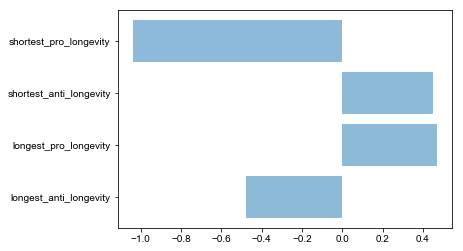

In [16]:
f = h['taxon_id']==9606
v = h[f]['fold_enrichment']
l = h[f]['joined_label']
plt.barh(l, v, align='center', alpha=0.5)

if save_images:
    export.export_image(
        '200130_hagr_ratio_for_short_and_long_genes/human.pdf'
    )

In [17]:
h[f]

,annotation,fold_enrichment,pvalue,bonferroni,benjamini_hochberg,in_significant,in_background,taxon_id,genes,joined_label
3,anti_longevity,-0.4754,0.0570691,0.114138,0.0570691,30,417,9606,longest,longest_anti_longevity
2,pro_longevity,0.47037,0.0395208,0.0790415,0.0570691,37,267,9606,longest,longest_pro_longevity
1,anti_longevity,0.450599,0.0162659,0.0325319,0.0162659,57,417,9606,shortest,shortest_anti_longevity
0,pro_longevity,-1.03864,0.00374448,0.00748897,0.00748897,13,267,9606,shortest,shortest_pro_longevity


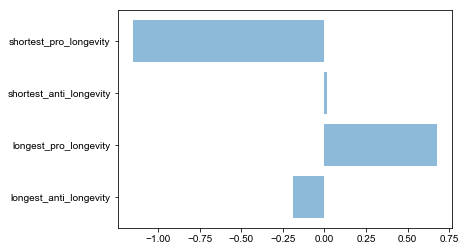

In [18]:
f = h['taxon_id']==10090
v = h[f]['fold_enrichment']
l = h[f]['joined_label']
plt.barh(l, v, align='center', alpha=0.5)

if save_images:
    export.export_image(
        '200130_hagr_ratio_for_short_and_long_genes/mouse.pdf'
    )

In [19]:
h[f]

,annotation,fold_enrichment,pvalue,bonferroni,benjamini_hochberg,in_significant,in_background,taxon_id,genes,joined_label
7,anti_longevity,-0.18548,0.563477,1,0.563477,27,307,10090,longest,longest_anti_longevity
6,pro_longevity,0.677871,0.00841823,0.0168365,0.0168365,32,200,10090,longest,longest_pro_longevity
5,anti_longevity,0.0148347,0.923389,1,0.923389,31,307,10090,shortest,shortest_anti_longevity
4,pro_longevity,-1.1512,0.00608579,0.0121716,0.0121716,9,200,10090,shortest,shortest_pro_longevity
